## Test Bench
This  notebook is used to evaluate the performance of a compression algorithm.

It is written such that a new compression algorithm can be added without altering the bench (just change the input in the config).

In [2]:
# ADD NEW ALGORITHMS HERE
#from alg_nocomp import NoCompression
#from alg_wkt_raw import WktRaw
#from alg_wkt_comp import WktComp
from alg_meta_aside_comp import SetAsideCompression


# CONFIG
ALG = SetAsideCompression()
DATASET_PATH = "data/lund_building_highway.json"
NBR_ITER = 100

COMPR_PATH = "data/testbench_compressed_single"
#COMPR_PATH = "data/testbench_compressed"

DECOMPR_PATH = "data/testbench_decompressed_single"

In [3]:
import time
import os
from enum import Enum
import pandas as pd
from datetime import datetime
import filecmp
import random
import json
import tqdm
from shapely.geometry import shape
import glob

# List the metrics which are to be logged
ET = Enum('ET', ['COMP_TIME', 'DECOMP_TIME', 'COMP_SIZE', 'DECOMP_SIZE',
    'VERTICES', 'TYPE', 'BOUNDING_BOX', 'ADD_VERTEX', 'IS_INTERSECTING', 'INTERSECTION'
]) # EVAL_TYPE

if not os.path.exists(COMPR_PATH):
   os.makedirs(COMPR_PATH)
for f in glob.glob(COMPR_PATH + '/*'):
    os.remove(f)
if not os.path.exists(DECOMPR_PATH):
   os.makedirs(DECOMPR_PATH)
for f in glob.glob(DECOMPR_PATH + '/*'):
    os.remove(f)

### Benchmarking
Run the compression, decompression, along with the operations, and store the measurements. Done NBR_ITER times to average.

In [4]:
# Maps an evaluation type to the corresponding function in the algorithm.
# Note that ALG (global variable) can change, so a function is used.
from functools import reduce
import operator


def et_to_func():
    return {
        ET.VERTICES: ALG.vertices, 
        ET.TYPE: ALG.type,
        ET.BOUNDING_BOX: ALG.bounding_box,
        ET.ADD_VERTEX: ALG.add_vertex, 
        ET.IS_INTERSECTING: ALG.is_intersecting, 
        ET.INTERSECTION: ALG.intersection 
        }

# Params: "et: EVAL_TYPE, idx: geometry index to query, value_only: dont save entry in log"
def measure(et, args, value_only=False): # Works for functions taking only a geometry 'idx' as parameter
    """
    Takes an evaluation type and executes the corresponding operation, storing the execution time and resulting value.
    Also returns the resulting value of the operation.
    """
    func = et_to_func()[et] # Find the function to be called
    t, v = func(args)
    if not value_only:
        res[et].append(t)
        vals[et].append(v)
    return v

SEED = 123
random.seed(SEED) # If we want to enforce the same ordering and indexes for multiple runs

res = {x: [] for x in ['idx_unary', 'idx_binary'] + list(ET)} # Store the 'results' of the measurements
vals = {x: [] for x in ['idx_unary', 'idx_binary'] + list(ET)[4:]} # Store the 'values' for the operations, to perform correctness check later

# Extract the nested feature attribute of the geo_json file containing the geometries
with open(DATASET_PATH, 'r') as f:
    data = json.loads(f.read())
file_df: pd.DataFrame = pd.json_normalize(data, record_path=['features'])
# Create a dataframe suitable for the WKT format for easy convertion to shapely objects
df = pd.DataFrame(
    {'type': file_df['geometry.type'], 'coordinates': file_df['geometry.coordinates']})

max_idx = len(df) - 1
unary_idxs = [random.randint(0, max_idx) for i in range(NBR_ITER)] # Generate list of indexes to query on
binary_idxs = [(random.randint(0, max_idx), random.randint(0, max_idx)) for i in range(NBR_ITER)] # Generate pair of indexes to query on. # TODO: Better selection than random

def compress(data, file_comp):
    # Compress
    geometry = shape(data)
    t, bin = ALG.compress(geometry)

    # Write to disk
    f = open(file_comp, "wb")
    f.write(bin)
    f.close()
    return t, bin

# Compress files, benchmark unaries
for idx in unary_idxs: # List of single idxs
    file_comp = f"{COMPR_PATH}/{idx}"
    t, _ = compress(df.iloc[idx], file_comp)
    res[ET.COMP_TIME].append(t) # Store delta time
    res[ET.COMP_SIZE].append(os.stat(file_comp).st_size) # Store compressed file size

for idx in list(reduce(operator.concat, binary_idxs)): # List of pairs collapsed
    file_comp = f"{COMPR_PATH}/{idx}"
    compress(df.iloc[idx], file_comp)

for i in tqdm.tqdm(range(len(unary_idxs))):
# ------------ UNARY ------------ #
    idx = unary_idxs[i]
    file_comp = f"{COMPR_PATH}/{idx}"
    file_decomp = f"{DECOMPR_PATH}/{idx}"

    res["idx_unary"].append(idx)
    vals["idx_unary"].append(idx)

    # Read binary into memory
    f = open(file_comp, "rb")
    bin = f.read()
    f.close()

    # Decompress
    t, decomp = ALG.decompress(bin)
    # Write to disk
    f = open(file_decomp, "w")
    f.write(decomp)
    f.close()
    res[ET.DECOMP_TIME].append(t) # Store delta time
    res[ET.DECOMP_SIZE].append(os.stat(file_decomp).st_size) # Store decompressed file size

    measure(ET.VERTICES, bin)
    measure(ET.TYPE, bin)
    measure(ET.BOUNDING_BOX, bin)
    measure(ET.ADD_VERTEX, (bin, 2, 24.5))

for i in tqdm.tqdm(range(len(binary_idxs))):
# ------------ BINARY ------------ #
    l_idx, r_idx = binary_idxs[i]

    res["idx_binary"].append(binary_idxs[i])
    vals["idx_binary"].append(binary_idxs[i])

    # Read both binary into memory
    f = open(f"{COMPR_PATH}/{l_idx}", "rb")
    l_bin = f.read()
    f.close()

    f = open(f"{COMPR_PATH}/{r_idx}", "rb")
    r_bin = f.read()
    f.close()

    measure(ET.IS_INTERSECTING, (l_bin, r_bin))
    measure(ET.INTERSECTION, (l_bin, r_bin))

df = pd.DataFrame(res)
df.loc['mean'] = df.mean()
print("Geometry count:", max_idx + 1)
df

  0%|          | 0/100 [00:00<?, ?it/s]


TypeError: object of type 'int' has no len()

### Plot the Results

Compression Ratio: 1.2239211014032298


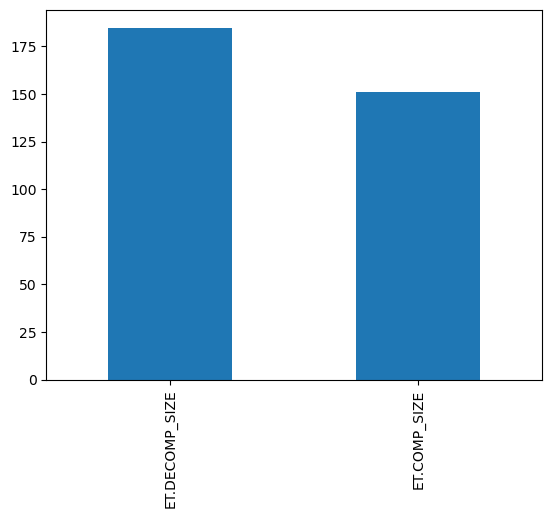

In [4]:
averages = df.iloc[-1]
sizes = averages[[ET.DECOMP_SIZE, ET.COMP_SIZE]]
sizes.plot.bar()
print("Compression Ratio:", sizes[0] / sizes[1])

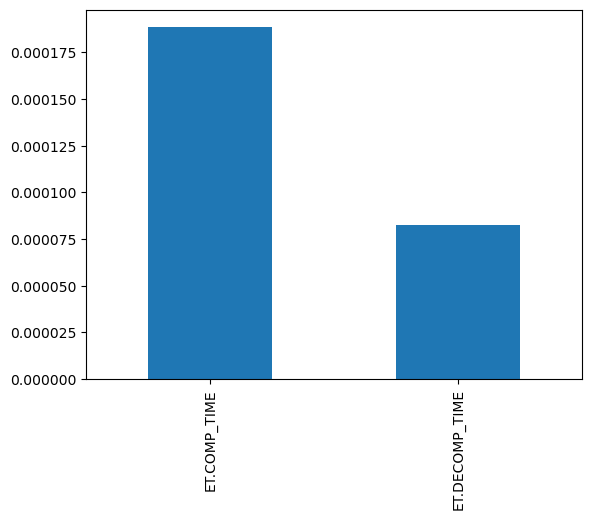

In [5]:
comp_decomp_times = averages[[ET.COMP_TIME, ET.DECOMP_TIME]].plot.bar()

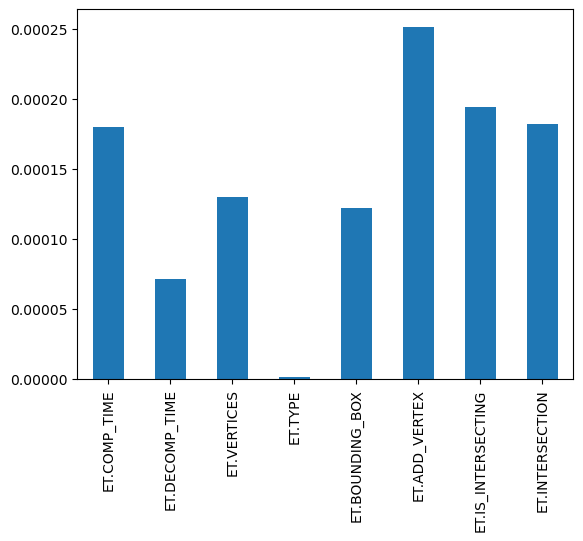

In [12]:
times = averages.drop(['idx_unary', 'idx_binary', ET.COMP_SIZE, ET.DECOMP_SIZE])
times.plot.bar();

### Export to CSV

In [ ]:
# Exports in the format: 2023-02-13_17:09:12_NoCompression.
df.to_csv("reports/" + datetime.now().strftime("%Y-%m-%d_%H:%M:%S") + "_" + ALG.__class__.__name__ + ".csv")

### Verify Integrity
Need to check that the operations are correct and that the decompression is lossless.

In [ ]:
# Is decompressed file equal to original?
#assert(filecmp.cmp(DECOMPR_PATH, DATASET_PATH, shallow=False))

df = pd.DataFrame(vals)
old_ALG = ALG

# Validate the operations, i.e. verify that "results of the operations performed above" == "the results using no compression".
ALG = NoCompression(DATASET_PATH) # Alter global compression algorithm, used in 'measure_unary()'
for _, r in df.iterrows():
    # The operations that are checked here (supported by "measure_unary"):
    unary_operations = [ET.VERTICES, ET.TYPE, ET.VERTEX_COUNT, ET.AREA, ET.LENGTH]
    for uop in unary_operations:
        v_no_compression = measure_unary(uop, r.idx, value_only=True)
        assert(v_no_compression == r[uop])

ALG = old_ALG

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()